In [1]:
!pip install simpy
!pip install numpy

 levels of patient urgency to corresponding average waiting time ranges in an emergency department


    waiting_time_ranges = {
        1: (0, 0),      # Level 1: Immediately
        2: (1, 14),     # Level 2: 1-14 minutes
        3: (15, 60),    # Level 3: 15-60 minutes
        4: (60, 120),   # Level 4: 1-2 hours
        5: (120, 1440)  # Level 5: 2-24 hours
    }
    

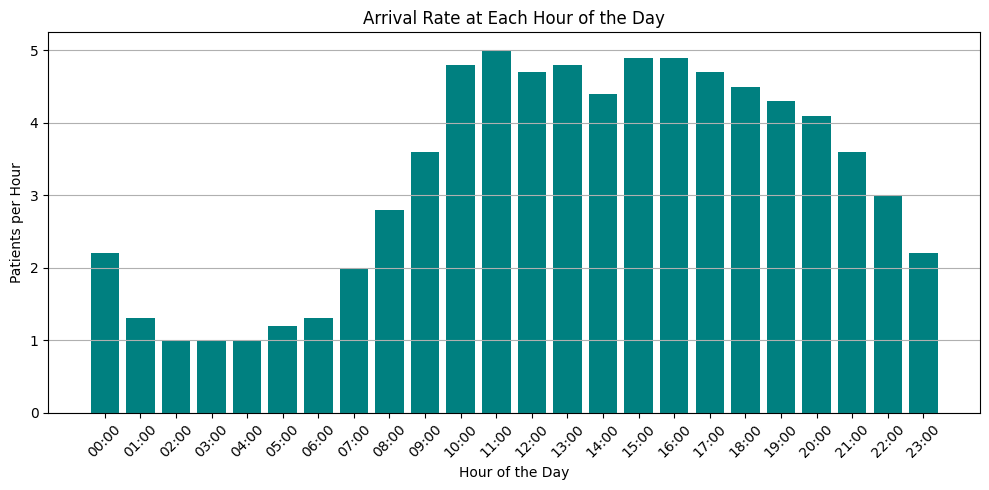

In [ ]:
import matplotlib.pyplot as plt

#patients arrival rates per hour
arrival_rates = [2.2,1.3, 1, 1, 1, 1.2, 1.3, 2, 2.8, 3.6, 4.8, 5, 4.7, 4.8, 4.4, 4.9, 4.9, 4.7, 4.5, 4.3, 4.1, 3.6, 3, 2.2]

# Plotting the arrival rates
plt.figure(figsize=(10, 5))
plt.bar(range(24), arrival_rates, color='teal')
plt.title('Arrival Rate at Each Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Patients per Hour')
plt.xticks(range(0, 24), labels=[f"{hour:02d}:00" for hour in range(24)], rotation=45)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


# HOSPITAL EMERGENCY DEPARTMENT DES: STATIC ALLOCATION OF RESOURCES #

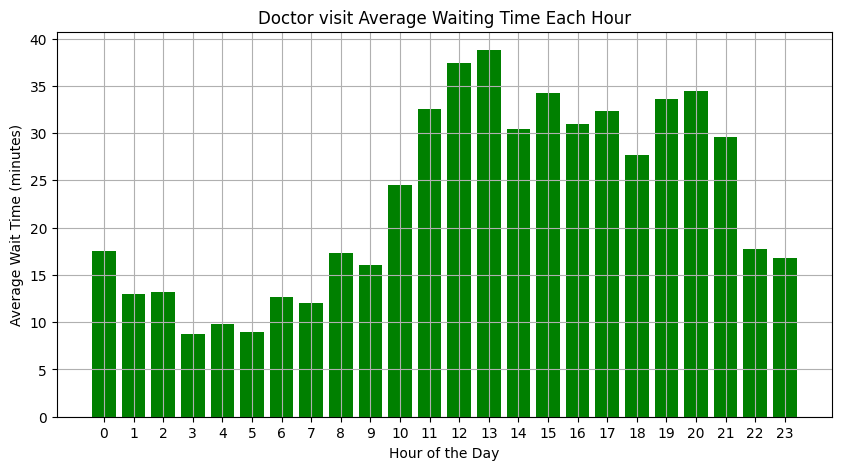

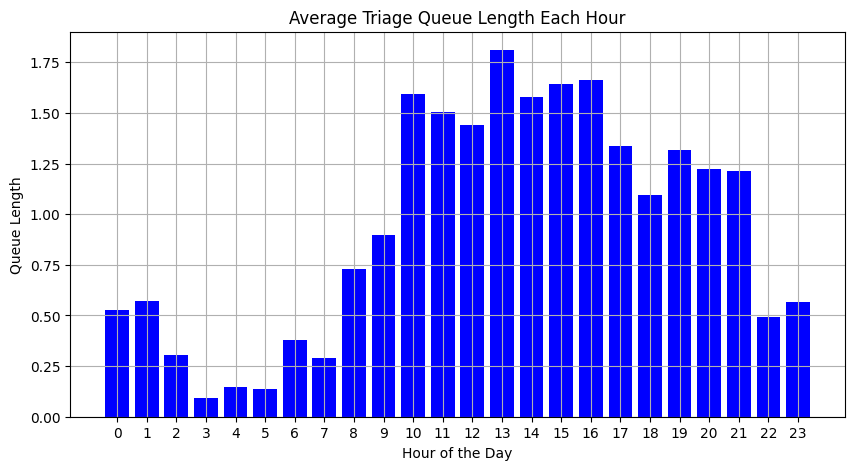

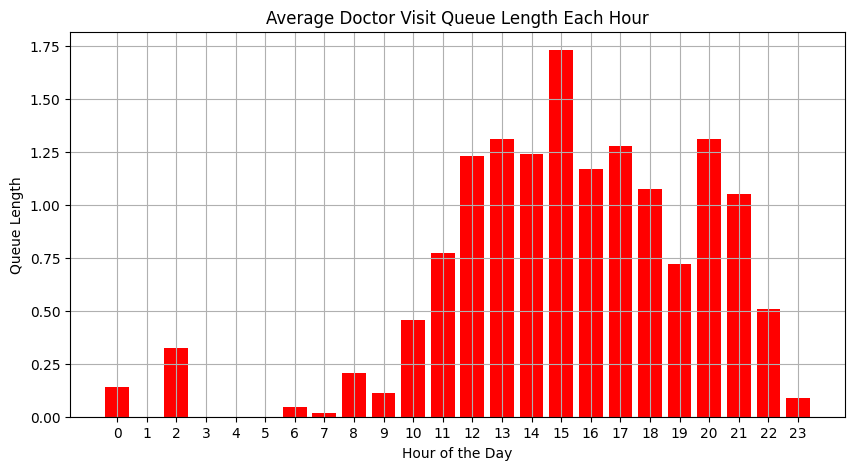

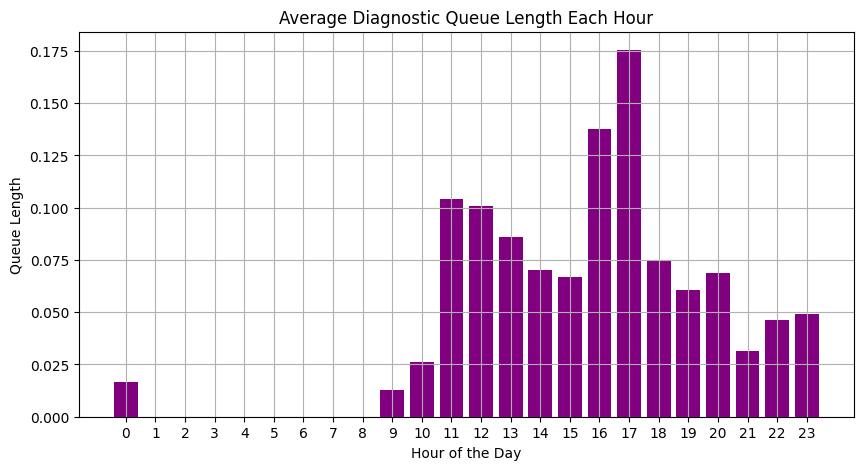

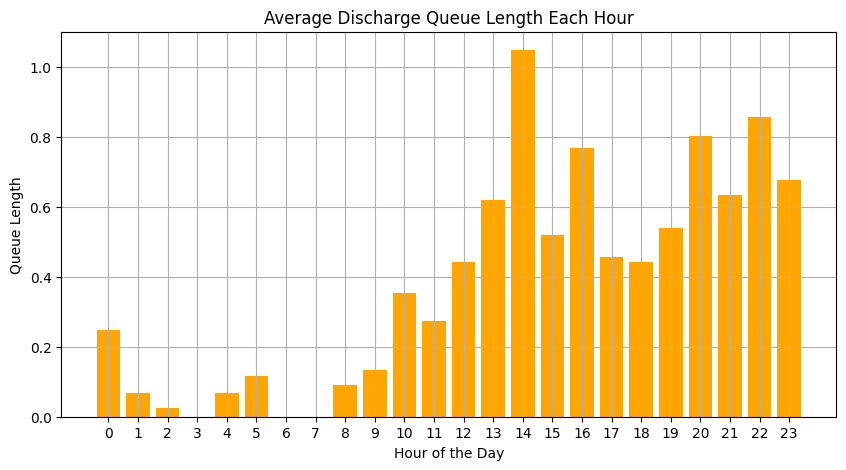

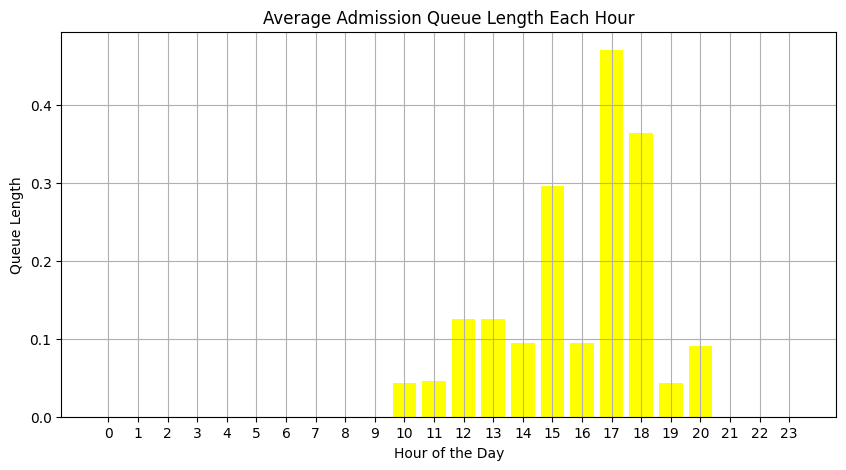

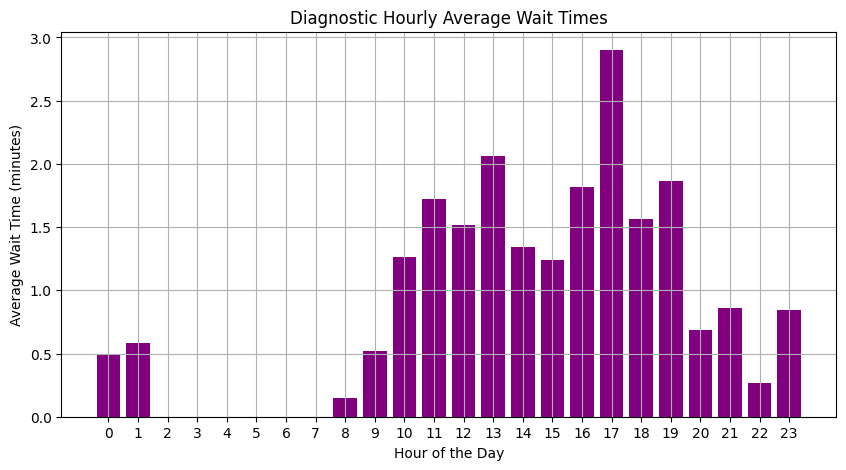

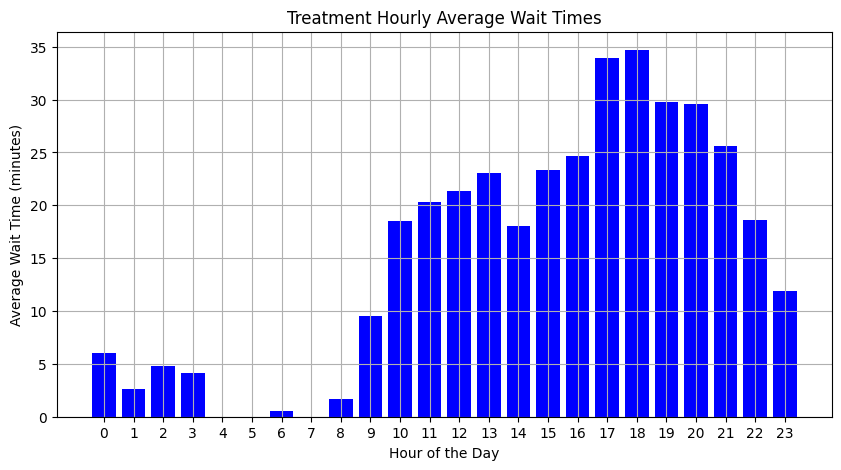

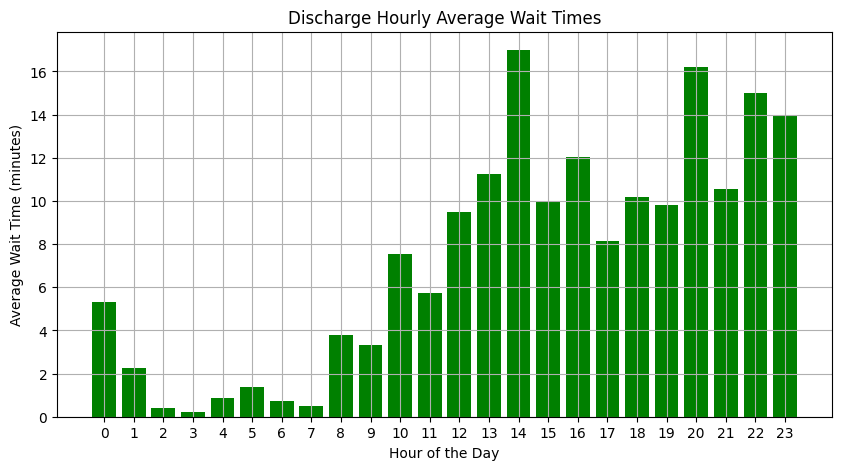

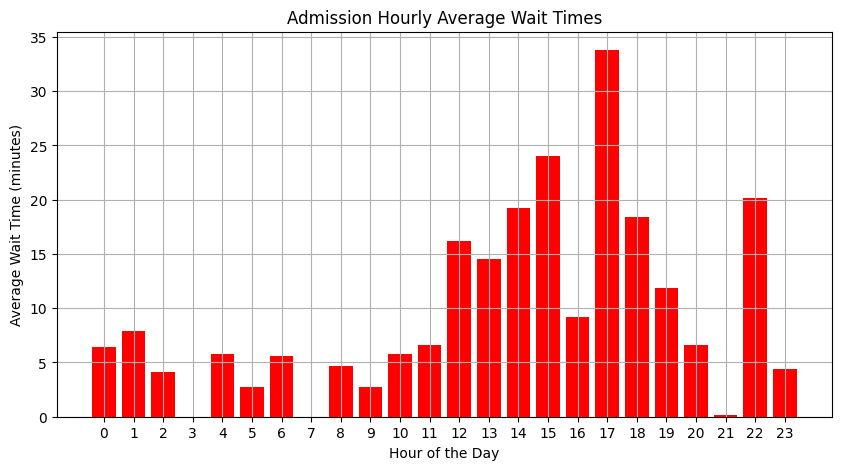

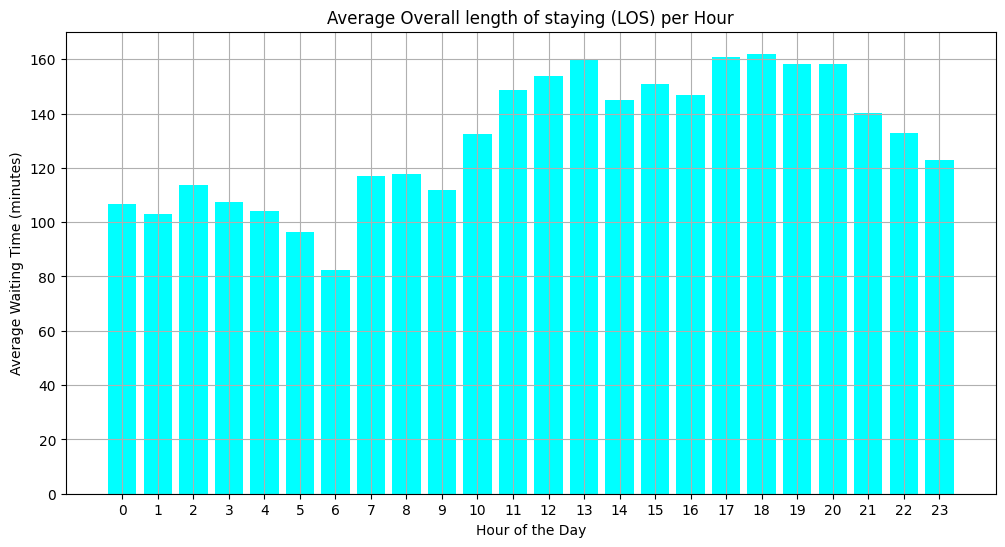

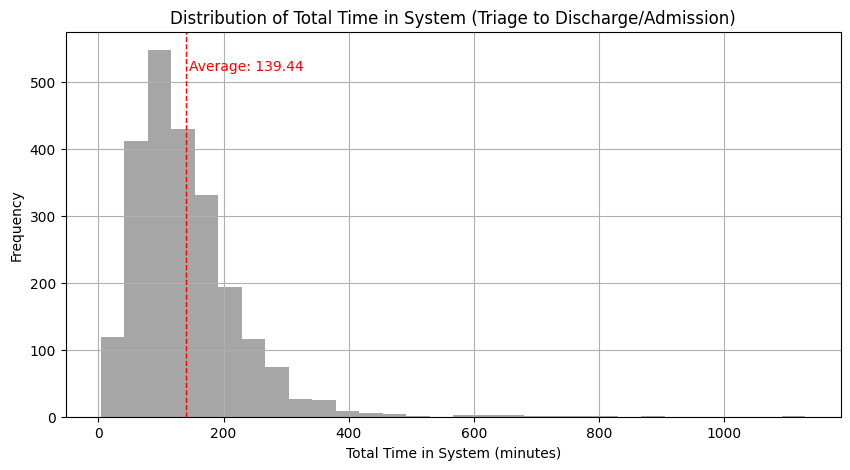

Average Wait Time for Doctor Service: 26.96 minutes
Maximum Wait Time for Doctor Service: 373.58 minutes
Average Wait Time for Diagnostic Service: 1.20 minutes
Maximum Wait Time for Diagnostic Service: 83.69 minutes
Average Wait Time for Treatment Service: 19.55 minutes
Maximum Wait Time for Treatment Service: 941.43 minutes
Average Wait Time for Discharge Service: 8.82 minutes
Maximum Wait Time for Discharge Service: 132.78 minutes
Average Wait Time for Admission Service: 12.16 minutes
Maximum Wait Time for Admission Service: 201.71 minutes
Total patients processed: 2305
Utilization Rate for Triage: 26.51%
Utilization Rate for Doctor: 51.72%
Utilization Rate for Diagnostic: 28.24%
Utilization Rate for Treatment: 53.75%
Utilization Rate for Discharge: 46.18%
Utilization Rate for Admission: 23.13%
Total patients processed: 2305


In [3]:
## HOSPITAL EMERGENCY DEPARTMENT DES ###

import simpy
import random
import matplotlib.pyplot as plt
import numpy as np

def reset_daily_stats(stats):
    # average queue lengths
    stats['hourly_queue_lengths_triage'] = [[] for _ in range(24)]
    stats['hourly_queue_lengths_treatment'] = [[] for _ in range(24)]
    stats['hourly_queue_lengths_diagnostic'] = [[] for _ in range(24)]
    stats['hourly_queue_lengths_discharge'] = [[] for _ in range(24)]
    stats['hourly_queue_lengths_admission'] = [[] for _ in range(24)]
    stats['hourly_queue_lengths_doctors']= [[] for _ in range(24)]
    #waiting times
    stats['total_wait_times'] = []
    stats['length_of_stay'] = []
    stats['total_time_in_system'] = []  # From triage to discharge/admission!! which is the overall LOS (length of stay)
    stats['hourly_wait_times_doctor'] = [[] for _ in range(24)]
    stats['hourly_wait_times_triage'] = [[] for _ in range(24)]
    stats['hourly_wait_times_diagnostic'] = [[] for _ in range(24)]
    stats['hourly_wait_times_treatment'] = [[] for _ in range(24)]
    stats['hourly_wait_times_discharge'] = [[] for _ in range(24)]
    stats['hourly_wait_times_admission'] = [[] for _ in range(24)]
    stats['hourly_total_waiting_times'] = [[] for _ in range(24)]  # Track total waiting time per hour
    #to track the utilization rate
    stats['hourly_service_times_triage'] = [[] for _ in range(24)]
    stats['hourly_service_times_doctor'] = [[] for _ in range(24)]
    stats['hourly_service_times_diagnostic'] = [[] for _ in range(24)]
    stats['hourly_service_times_treatment'] = [[] for _ in range(24)]
    stats['hourly_service_times_discharge'] = [[] for _ in range(24)]
    stats['hourly_service_times_admission'] = [[] for _ in range(24)]

def patient(env, name, triage_nurses, doctors, diagnostic_stations, treatment_stations, discharge_service, admission_service, stats, start_hour, urgency_level):
    arrival_time = env.now

    # Decisions for this patient
    needs_diagnostic = random.choices([True, False], weights=[79.1, 20.9], k=1)[0]
    needs_treatment = random.choices([True, False], weights=[76.2, 23.8], k=1)[0]
    condition_for_discharge = random.choices([True, False], weights=[84.9, 13.1], k=1)[0]

    # Handling triage + doctor visit with priority
    if stats is not None:
        stats['hourly_queue_lengths_triage'][start_hour].append(len(triage_nurses.queue))
    with triage_nurses.request() as req:
        yield req
        triage_completed_time = env.now
        stats['hourly_wait_times_triage'] = triage_completed_time - arrival_time
        triage_service_duration = random.expovariate(1/5)  # Time for triage
        yield env.timeout(triage_service_duration)
    if stats is not None:
        stats['hourly_queue_lengths_doctors'][start_hour].append(len(doctors.queue))
        stats['hourly_service_times_triage'][start_hour].append(triage_service_duration)


    with doctors.request(priority=urgency_level) as req:
        yield req
        doctor_visit_start_time = env.now
        doctor_service_duration = random.expovariate(1/20)  # Time for doctor visit
        if stats is not None:
            wait_time = doctor_visit_start_time - arrival_time
            stats['total_wait_times'].append(wait_time)
            stats['hourly_wait_times_doctor'][start_hour].append(wait_time)
        yield env.timeout(doctor_service_duration)
        doctor_visit_end_time = env.now
        if stats is not None:
            length_of_stay = doctor_visit_end_time - arrival_time
            stats['length_of_stay'].append(length_of_stay)
            stats['hourly_service_times_doctor'][start_hour].append(doctor_service_duration)

    # Handling diagnostics with priority
    if needs_diagnostic:
        diagnostic_wait_start = env.now
        if stats is not None:
            stats['hourly_queue_lengths_diagnostic'][start_hour].append(len(diagnostic_stations.queue))
        with diagnostic_stations.request(priority=urgency_level) as req:
            yield req
            diagnostic_wait_end = env.now
            diagnostic_service_time= random.expovariate(1/20) # Time for diagnostic
            if stats is not None:
                stats['hourly_wait_times_diagnostic'][start_hour].append(diagnostic_wait_end - diagnostic_wait_start)
                stats['hourly_service_times_diagnostic'][start_hour].append(diagnostic_service_time)
            yield env.timeout(diagnostic_service_time)

    # Handling treatment with priority
    if needs_treatment:
        treatment_wait_start = env.now  # Start waiting time
        if stats is not None:
            stats['hourly_queue_lengths_treatment'][start_hour].append(len(treatment_stations.queue))
        with treatment_stations.request(priority=urgency_level) as req:
            yield req
            treatment_wait_end = env.now  # End waiting time
            treatment_service_time= random.expovariate(1/40) # Time for treatment
            if stats is not None:
                stats['hourly_wait_times_treatment'][start_hour].append(treatment_wait_end - treatment_wait_start)
                stats['hourly_service_times_treatment'][start_hour].append(treatment_service_time)
            yield env.timeout(treatment_service_time)

    # Decide whether to discharge or admit
    final_process_start = env.now
    if condition_for_discharge:
        discharge_wait_start = env.now  # Start waiting time
        if stats is not None:
            stats['hourly_queue_lengths_discharge'][start_hour].append(len(discharge_service.queue))
        with discharge_service.request() as req:
            yield req
            discharge_wait_end = env.now  # End waiting time
            discharge_service_time= random.expovariate(1/20)
            if stats is not None:
                stats['hourly_wait_times_discharge'][start_hour].append(discharge_wait_end - discharge_wait_start)
                stats['hourly_service_times_discharge'][start_hour].append(discharge_service_time)
            yield env.timeout(discharge_service_time)
    else:
        admission_wait_start = env.now  # Start waiting time
        if stats is not None:
            stats['hourly_queue_lengths_admission'][start_hour].append(len(admission_service.queue))
        with admission_service.request() as req:
            yield req
            admission_wait_end = env.now  # End waiting time
            admission_service_time= random.expovariate(1/30) # Time for admission
            if stats is not None:
                stats['hourly_wait_times_admission'][start_hour].append(admission_wait_end - admission_wait_start)
                stats['hourly_service_times_admission'][start_hour].append(admission_service_time)
            yield env.timeout(admission_service_time)
    final_process_end = env.now

    # Calculate the total time in the system
    if stats is not None:
        total_waiting_time = final_process_end - arrival_time
        stats['total_time_in_system'].append(total_waiting_time)
        stats['hourly_total_waiting_times'][start_hour].append(total_waiting_time)


def run_emergency_dept(env, num_triage_nurses, num_doctors, num_diagnostic_stations, num_treatment_stations, stats, warmup_days, total_days,num_discharge_stations,num_admission_stations):
    reset_daily_stats(stats)  # stats must reset before simulation starts
    triage_nurses = simpy.Resource(env, capacity=num_triage_nurses)
    doctors = simpy.PriorityResource(env, capacity=num_doctors)
    diagnostic_stations = simpy.PriorityResource(env, capacity=num_diagnostic_stations)
    treatment_stations = simpy.PriorityResource(env, capacity=num_treatment_stations)
    discharge_service = simpy.Resource(env, capacity=num_discharge_stations)
    admission_service = simpy.Resource(env, capacity=num_admission_stations)

    hourly_rates = [rate / 60 for rate in [2.2, 1.3, 1.1, 1, 1, 1.2, 1.3, 2, 2.8, 3.6, 4.8, 5, 4.7, 4.8, 4.4, 4.9, 4.9, 4.7, 4.5, 4.3, 4.1, 3.6, 3, 2.2]]

    # Run simulation for warmup period without collecting data
    for day in range(warmup_days):
        for hour in range(24):
            expected_count = hourly_rates[hour] * 60
            arrivals = np.random.poisson(expected_count)
            for _ in range(arrivals):
                urgency_level = random.choices([1, 2, 3, 4, 5], weights=[0.9, 13.1, 57.0, 24.8, 4.2], k=1)[0]
                env.process(patient(env, f'Patient {day*1440 + hour*60 + _}', triage_nurses, doctors, diagnostic_stations, treatment_stations, discharge_service, admission_service, stats, hour, urgency_level))
            yield env.timeout(60)
    # Reset stats for actual data collection
    reset_daily_stats(stats)
    # Run simulation for actual data collection period
    for day in range(total_days):
        for hour in range(24):
            expected_count = hourly_rates[hour] * 60
            arrivals = np.random.poisson(expected_count)
            for _ in range(arrivals):
                urgency_level = random.choices([1, 2, 3, 4, 5], weights=[0.9, 13.1, 57.0, 24.8, 4.2], k=1)[0]
                env.process(patient(env, f'Patient {(warmup_days+day)*1440 + hour*60 + _}', triage_nurses, doctors, diagnostic_stations, treatment_stations, discharge_service, admission_service, stats, hour, urgency_level))
            yield env.timeout(60)

# Initialize the environment and run the simulation
env = simpy.Environment()
stats = {}

##different configurations set of resources!!!!

#env.process(run_emergency_dept(env, num_triage_nurses=1, num_doctors=3, num_diagnostic_stations=3, num_treatment_stations=3, stats=stats, warmup_days=14, total_days=30, num_discharge_stations=1, num_admission_stations=1))
#env.process(run_emergency_dept(env, num_triage_nurses=1, num_doctors=2, num_diagnostic_stations=2, num_treatment_stations=2, stats=stats, warmup_days=14, total_days=30, num_discharge_stations=1, num_admission_stations=1))
#env.process(run_emergency_dept(env, num_triage_nurses=1, num_doctors=2, num_diagnostic_stations=3, num_treatment_stations=3, stats=stats, warmup_days=14, total_days=30, num_discharge_stations=1, num_admission_stations=1))
#env.process(run_emergency_dept(env, num_triage_nurses=1, num_doctors=4, num_diagnostic_stations=2, num_treatment_stations=2, stats=stats, warmup_days=14, total_days=30, num_discharge_stations=1, num_admission_stations=1))
env.process(run_emergency_dept(env, num_triage_nurses=1, num_doctors=2, num_diagnostic_stations=3, num_treatment_stations=3, stats=stats, warmup_days=10, total_days=30, num_discharge_stations=2, num_admission_stations=1))
env.run()

# Calculate and plot the average wait time for each hour for each queue
average_doctor_visit_wait_times = [sum(times) / len(times) if times else 0 for times in stats['hourly_wait_times_doctor']]
average_queue_lengths_triage = [sum(lengths) / len(lengths) if lengths else 0 for lengths in stats['hourly_queue_lengths_triage']]
hourly_queue_lengths_doctors = [sum(lengths) / len(lengths) if lengths else 0 for lengths in stats['hourly_queue_lengths_doctors']]

# Plotting the average wait times for doctor visit
plt.figure(figsize=(10, 5))
plt.bar(range(24), average_doctor_visit_wait_times, color='green')
plt.title('Doctor visit Average Waiting Time Each Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Wait Time (minutes)')
plt.xticks(range(0, 24, 1))
plt.grid(True)
plt.show()

# Plotting the average queue lengths for triage
plt.figure(figsize=(10, 5))
plt.bar(range(24), average_queue_lengths_triage, color='blue')
plt.title('Average Triage Queue Length Each Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Queue Length')
plt.xticks(range(0, 24, 1))
plt.grid(True)
plt.show()

# Plotting the average queue lengths for Doctor visit
plt.figure(figsize=(10, 5))
plt.bar(range(24), hourly_queue_lengths_doctors, color='red')
plt.title('Average Doctor Visit Queue Length Each Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Queue Length')
plt.xticks(range(0, 24, 1))
plt.grid(True)
plt.show()

# Function to plot average queue lengths
def plot_queue_lengths(stats, title, color):
    average_lengths = [sum(lengths) / len(lengths) if lengths else 0 for lengths in stats]
    plt.figure(figsize=(10, 5))
    plt.bar(range(24), average_lengths, color=color)
    plt.title(title)
    plt.xlabel('Hour of the Day')
    plt.ylabel('Queue Length')
    plt.xticks(range(0, 24, 1))
    plt.grid(True)
    plt.show()

# Plot for each queue
plot_queue_lengths(stats['hourly_queue_lengths_diagnostic'], 'Average Diagnostic Queue Length Each Hour', 'purple')
plot_queue_lengths(stats['hourly_queue_lengths_discharge'], 'Average Discharge Queue Length Each Hour', 'orange')
plot_queue_lengths(stats['hourly_queue_lengths_admission'], 'Average Admission Queue Length Each Hour', 'yellow')

def plot_hourly_wait_times(stats, title, color):
    hourly_avg_wait_times = [sum(times) / len(times) if times else 0 for times in stats]
    plt.figure(figsize=(10, 5))
    plt.bar(range(24), hourly_avg_wait_times, color=color)
    plt.title(title)
    plt.xlabel('Hour of the Day')
    plt.ylabel('Average Wait Time (minutes)')
    plt.xticks(range(0, 24, 1))
    plt.grid(True)
    plt.show()

def plot_hourly_overall_waiting_time(stats):
    # Calculate average waiting times for each hour
    hourly_avg_waiting_times = [sum(times) / len(times) if times else 0 for times in stats['hourly_total_waiting_times']]
    plt.figure(figsize=(12, 6))
    plt.bar(range(24), hourly_avg_waiting_times, color='cyan')
    plt.title('Average Overall length of staying (LOS) per Hour')
    plt.xlabel('Hour of the Day')
    plt.ylabel('Average Waiting Time (minutes)')
    plt.xticks(range(24))
    plt.grid(True)
    plt.show()

# Plot each queue's hourly waiting times for each different queue
plot_hourly_wait_times(stats['hourly_wait_times_diagnostic'], 'Diagnostic Hourly Average Wait Times', 'purple')
plot_hourly_wait_times(stats['hourly_wait_times_treatment'], 'Treatment Hourly Average Wait Times', 'blue')
plot_hourly_wait_times(stats['hourly_wait_times_discharge'], 'Discharge Hourly Average Wait Times', 'green')
plot_hourly_wait_times(stats['hourly_wait_times_admission'], 'Admission Hourly Average Wait Times', 'red')
plot_hourly_overall_waiting_time(stats)


# Function to plot overall waiting time
def plot_overall_waiting_time(stats):
    total_times = stats['total_time_in_system']
    average_total_time = sum(total_times) / len(total_times) if total_times else 0
    plt.figure(figsize=(10, 5))
    plt.hist(total_times, bins=30, color='gray', alpha=0.7)
    plt.title('Distribution of Total Time in System (Triage to Discharge/Admission)')
    plt.xlabel('Total Time in System (minutes)')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.axvline(average_total_time, color='red', linestyle='dashed', linewidth=1)
    plt.text(average_total_time + 5, plt.ylim()[1] * 0.9, f'Average: {average_total_time:.2f}', color='red')
    plt.show()

# Call the function to plot overall waiting time
plot_overall_waiting_time(stats)


def print_performance_stats(stats):
    # Calculate and print average and maximum wait times for various services
    for service in ['doctor', 'diagnostic', 'treatment', 'discharge', 'admission']:
        wait_times = [time for sublist in stats[f'hourly_wait_times_{service}'] for time in sublist]
        if wait_times:  # Check if the list is not empty
            average_wait_time = sum(wait_times) / len(wait_times)
            max_wait_time = max(wait_times)
            print(f"Average Wait Time for {service.capitalize()} Service: {average_wait_time:.2f} minutes")
            print(f"Maximum Wait Time for {service.capitalize()} Service: {max_wait_time:.2f} minutes")
        else:
            print(f"No wait time data for {service.capitalize()} service.")
    # Print total patients processed
    total_patients = sum([len(times) for times in stats['hourly_total_waiting_times']])
    print(f"Total patients processed: {total_patients}")

fixed_capacities = {
    'triage': 1,  # 2 triage
    'doctor': 2,  # 3 doctors
    'diagnostic': 3,  # 2 diagnostic
    'treatment': 3,  # 4 treatment
    'discharge': 2,  # 1 discharge
    'admission': 1   # 1 admission
}
def print_performance2_stats(stats, fixed_capacities):
    total_simulation_minutes = 24 * 60 * 30  # Total minutes in the simulation
    for service, capacity in fixed_capacities.items():
        # Calculate total service time for the service
        service_time = sum([sum(times) for times in stats[f'hourly_service_times_{service}']])
        # Calculate total available time for the service
        total_capacity_time = capacity * total_simulation_minutes
        # Calculate utilization rate
        utilization_rate = (service_time / total_capacity_time) * 100 if total_capacity_time > 0 else 0
        print(f"Utilization Rate for {service.capitalize()}: {utilization_rate:.2f}%")
    # Print total patients processed
    total_patients = sum([len(times) for times in stats['hourly_total_waiting_times']])
    print(f"Total patients processed: {total_patients}")

print_performance_stats(stats)
print_performance2_stats(stats, fixed_capacities)


#RESULTS FOR THE FOLLOWING SERVICE TIME SET:

*   triage assesment service time: 5 minutes
*   doctor visit service time: 20 minutes
*   diagnostic service time: 20 minutes
*   treatment service time: 40 minutes
*   discharge service time: 20 minuets
*   admission sevice time:  30 minutes



* RESOURCES SET 1: (num_triage_nurses=1, num_doctors=2, num_diagnostic_stations=2, num_treatment_stations=3, total_days=30, num_discharge_stations=1, num_admission_stations=1))

RESULTS SET 1:
* Average Wait Time for Doctor Service: 31.26 minutes
* Maximum Wait Time for Doctor Service: 453.93 minutes
* Average Wait Time for Diagnostic Service: 7.15 minutes
* Maximum Wait Time for Diagnostic Service: 175.18 minutes
* Average Wait Time for Treatment Service: 18.64 minutes
* Maximum Wait Time for Treatment Service: 853.18 minutes
* Average Wait Time for Discharge Service: 283.48 minutes
* Maximum Wait Time for Discharge Service: 876.05 minutes
* Average Wait Time for Admission Service: 7.89 minutes
* Maximum Wait Time for Admission Service: 145.91 minutes
* Total patients processed: 2303
* Utilization Rate for Triage: 26.93%
* Utilization Rate for Doctor: 52.53%
* Utilization Rate for Diagnostic: 41.09%
* Utilization Rate for Treatment: 54.46%
* Utilization Rate for Discharge: 90.93%
* Utilization Rate for Admission: 21.30%
* Total patients processed: 2303

* RESOURCES SET 2: ( num_triage_nurses=1, num_doctors=2, num_diagnostic_stations=3, num_treatment_stations=3, total_days=30, num_discharge_stations=2, num_admission_stations=1)

RESULTS SET 2:
* Average Wait Time for Doctor Service: 35.64 minutes
* Maximum Wait Time for Doctor Service: 475.55 minutes
* Average Wait Time for Diagnostic Service: 1.55 minutes
* Maximum Wait Time for Diagnostic Service: 55.87 minutes
* Average Wait Time for Treatment Service: 19.35 minutes
* Maximum Wait Time for Treatment Service: 407.64 minutes
* Average Wait Time for Discharge Service: 10.22 minutes
* Maximum Wait Time for Discharge Service: 124.90 minutes
* Average Wait Time for Admission Service: 8.99 minutes
* Maximum Wait Time for Admission Service: 116.74 minutes
* Total patients processed: 2331
* Utilization Rate for Triage: 26.90%
* Utilization Rate for Doctor: 51.73%
* Utilization Rate for Diagnostic: 29.00%
* Utilization Rate for Treatment: 54.19%
* Utilization Rate for Discharge: 45.36%
* Utilization Rate for Admission: 19.63%
* Total patients processed: 2331


#RESULTS FOR THE FOLLOWING SERVICE TIME SET:

*   triage assesment service time: 5 minutes
*   doctor visit service time: 20 minutes
*   diagnostic service time: 10 minutes
*   treatment service time: 20 minutes
*   discharge service time: 15 minuets
*   admission sevice time:  30 minutes



RESULTS FOR STATIC RESOURCES ALLOCATION 1:
* (num_triage_nurses=1, num_doctors=2, num_diagnostic_stations=2, num_treatment_stations=2, stats=stats, warmup_days=14, total_days=30, num_discharge_stations=1, num_admission_stations=1)


* Average Wait Time for Doctor Service: 35.29 minutes
* Maximum Wait Time for Doctor Service: 650.81 minutes
* Average Wait Time for Diagnostic Service: 0.74 minutes
* Maximum Wait Time for Diagnostic Service: 49.97 minutes
* Average Wait Time for Treatment Service: 5.48 minutes
* Maximum Wait Time for Treatment Service: 133.53 minutes
* Average Wait Time for Discharge Service: 78.87 minutes
* Maximum Wait Time for Discharge Service: 374.25 minutes
* Average Wait Time for Admission Service: 6.25 minutes
* Maximum Wait Time for Admission Service: 93.45 minutes
* Utilization Rate for Triage: 26.54%
* Utilization Rate for Doctor: 107.64%
* Utilization Rate for Diagnostic: 41.77%
* Utilization Rate for Treatment: 80.52%
* Utilization Rate for Discharge: 70.59%
* Utilization Rate for Admission: 18.41%
* AVERAGE OVERALL LENGTH OF STAYING: 147.87 minutes
* Total patients processed: 2295


RESULTS FOR STATIC RESOURCES ALLOCATION 2:
* ( num_triage_nurses=1, num_doctors=3, num_diagnostic_stations=3, num_treatment_stations=3, stats=stats, warmup_days=14, total_days=30, num_discharge_stations=1, num_admission_stations=1)




* Average Wait Time for Doctor Service: 35.64 minutes
* Maximum Wait Time for Doctor Service: 475.55 minutes
* Average Wait Time for Diagnostic Service: 1.55 minutes
* Maximum Wait Time for Diagnostic Service: 55.87 minutes
* Average Wait Time for Treatment Service: 19.35 minutes
* Maximum Wait Time for Treatment Service: 407.64 minutes
* Average Wait Time for Discharge Service: 10.22 minutes
* Maximum Wait Time for Discharge Service: 124.90 minutes
* Average Wait Time for Admission Service: 8.99 minutes
* Maximum Wait Time for Admission Service: 116.74 minutes
* Total patients processed: 2331
* Utilization Rate for Triage: 26.90%
* Utilization Rate for Doctor: 51.73%
* Utilization Rate for Diagnostic: 29.00%
* Utilization Rate for Treatment: 54.19%
* Utilization Rate for Discharge: 45.36%
* Utilization Rate for Admission: 19.63%
* Total patients processed: 2331



RESULTS FOR STATIC RESOURCES ALLOCATION 3:
* ( num_triage_nurses=1, num_doctors=2, num_diagnostic_stations=3, num_treatment_stations=3, stats=stats, warmup_days=14, total_days=30, num_discharge_stations=1, num_admission_stations=1)



* Average Wait Time for Doctor Service: 30.88 minutes
* Maximum Wait Time for Doctor Service: 434.05 minutes
* Average Wait Time for Diagnostic Service: 0.09 minutes
* Maximum Wait Time for Diagnostic Service: 12.29 minutes
* Average Wait Time for Treatment Service: 0.88 minutes
* Maximum Wait Time for Treatment Service: 90.60 minutes
* Average Wait Time for Discharge Service: 61.79 minutes
* Maximum Wait Time for Discharge Service: 461.15 minutes
* Average Wait Time for Admission Service: 18.71 minutes
* Maximum Wait Time for Admission Service: 245.36 minutes
* Utilization Rate for Triage: 27.91%
* Utilization Rate for Doctor: 106.57%
* Utilization Rate for Diagnostic: 43.66%
* Utilization Rate for Treatment: 79.96%
* Utilization Rate for Discharge: 71.31%
* Utilization Rate for Admission: 24.43%
* AVERAGE OVERALL LENGTH OF STAYING: 149.62 minutes
* Total patients processed: 2338




RESULTS FOR STATIC RESOURCES ALLOCATION 4:
* (num_triage_nurses=1, num_doctors=4, num_diagnostic_stations=2, num_treatment_stations=2, stats=stats, warmup_days=14, total_days=30, num_discharge_stations=1, num_admission_stations=1)



* Average Wait Time for Doctor Service: 15.39 minutes
* Maximum Wait Time for Doctor Service: 95.67 minutes
* Average Wait Time for Diagnostic Service: 0.97 minutes
* Maximum Wait Time for Diagnostic Service: 48.90 minutes
* Average Wait Time for Treatment Service: 8.32 minutes
* Maximum Wait Time for Treatment Service: 193.19 minutes
* Average Wait Time for Discharge Service: 59.60 minutes
* Maximum Wait Time for Discharge Service: 332.37 minutes
* Average Wait Time for Admission Service: 11.50 minutes
* Maximum Wait Time for Admission Service: 198.82 minutes
* Utilization Rate for Triage: 26.63%
* Utilization Rate for Doctor: 106.26%
* Utilization Rate for Diagnostic: 43.91%
* Utilization Rate for Treatment: 83.34%
* Utilization Rate for Discharge: 69.67%
* Utilization Rate for Admission: 21.86%
* AVERAGE OVERALL LENGTH OF STAYING: 162.62 minutes
* Total patients processed: 2308


RESULTS FOR STATIC RESOURCES ALLOCATION 5:
* ( num_triage_nurses=1, num_doctors=3, num_diagnostic_stations=3, num_treatment_stations=4, stats=stats, warmup_days=14, total_days=30, num_discharge_stations=1, num_admission_stations=1)


* Average Wait Time for Doctor Service: 18.65 minutes
* Maximum Wait Time for Doctor Service: 147.57 minutes
* Average Wait Time for Diagnostic Service: 0.09 minutes
* Maximum Wait Time for Diagnostic Service: 23.00 minutes
* Average Wait Time for Treatment Service: 0.21 minutes
* Maximum Wait Time for Treatment Service: 24.85 minutes
* Average Wait Time for Discharge Service: 65.34 minutes
* Maximum Wait Time for Discharge Service: 385.88 minutes
* Average Wait Time for Admission Service: 10.77 minutes
* Maximum Wait Time for Admission Service: 144.48 minutes
* Utilization Rate for Triage: 26.95%
* Utilization Rate for Doctor: 108.62%
* Utilization Rate for Diagnostic: 43.33%
* Utilization Rate for Treatment: 83.01%
* Utilization Rate for Discharge: 70.02%
* Utilization Rate for Admission: 20.57%
* AVERAGE OVERALL LENGTH OF STAYING: 137.42 minutes
* Total patients processed: 2333



# HOSPITAL EMERGENCY DEPARTMENT DES: DYNAMIC ALLOCATION OF RESOURCES

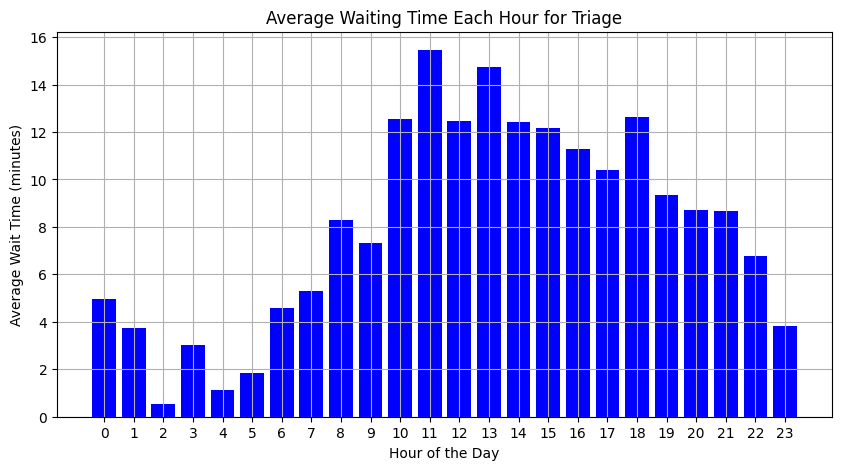

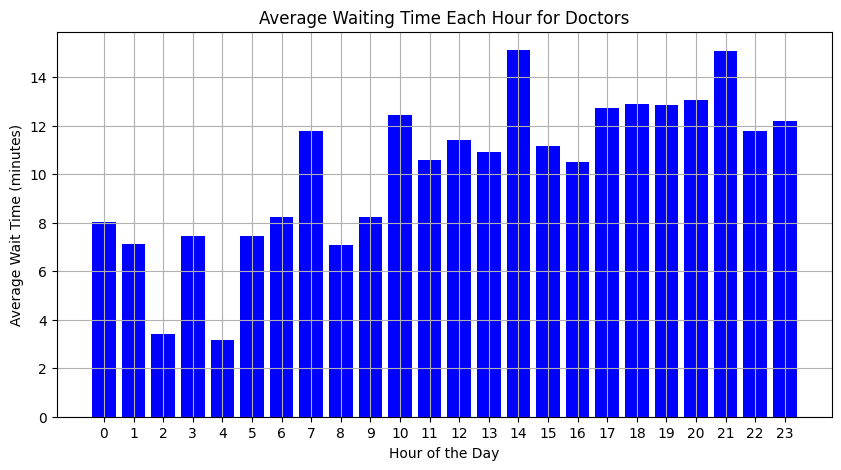

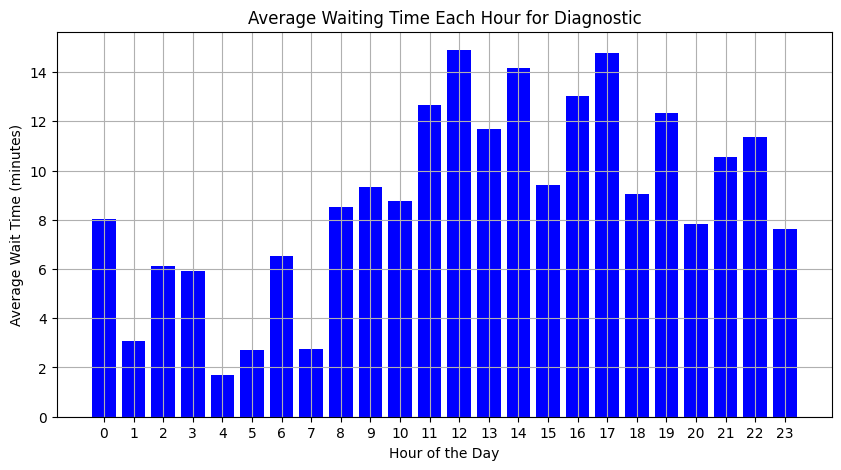

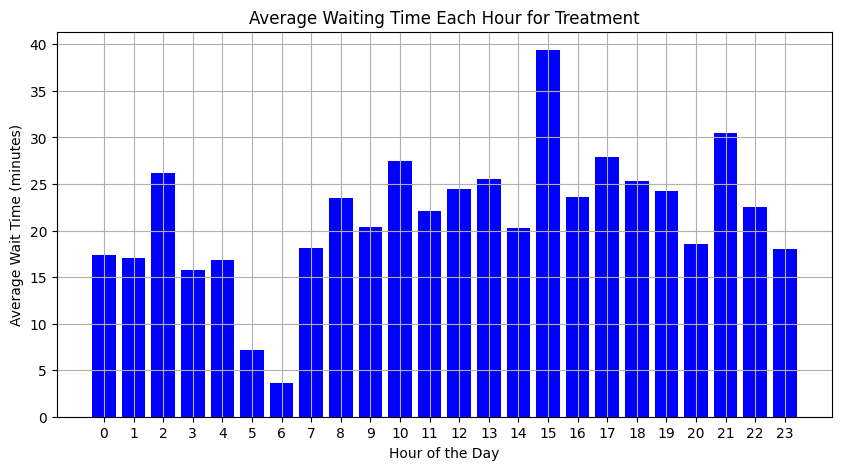

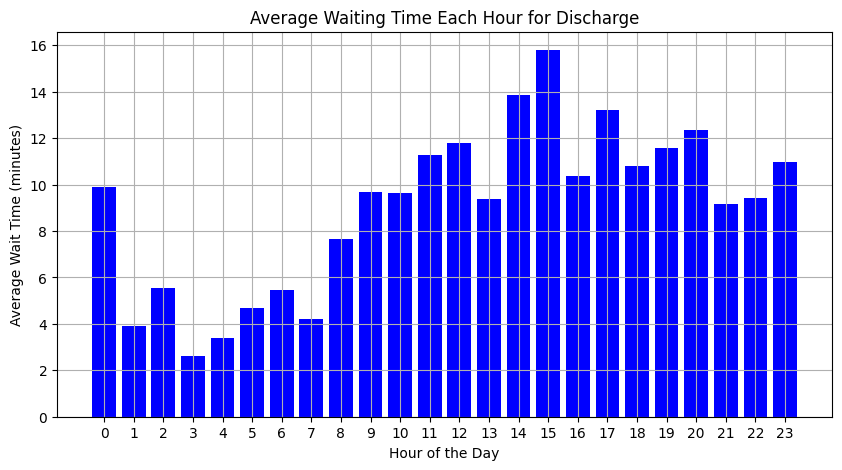

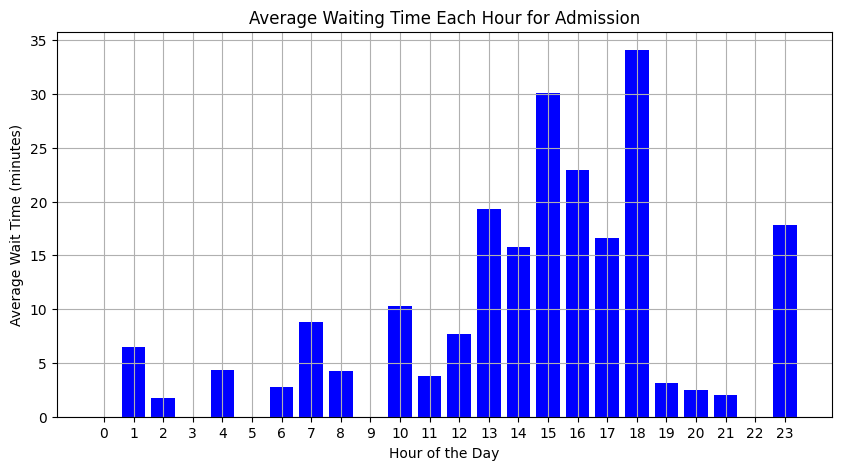

In [7]:
## HOSPITAL EMERGENCY DEPARTMENT DES: DYNAMIC ALLOCATION OF RESOURCES ### + more efficient implementation of the code

import simpy
import random
import numpy as np
import matplotlib.pyplot as plt

def reset_daily_stats(stats):
    stats.clear()
    stats.update({f'hourly_waiting_{resource}': [[] for _ in range(24)] for resource in ['triage', 'doctors', 'diagnostic', 'treatment', 'discharge', 'admission']})
    stats.update({f'hourly_queue_lengths_{resource}': [[] for _ in range(24)] for resource in ['triage', 'doctors', 'diagnostic', 'treatment', 'discharge', 'admission']})
    stats.update({f'hourly_service_times_{resource}': [[] for _ in range(24)] for resource in ['triage', 'doctors', 'diagnostic', 'treatment', 'discharge', 'admission']})
    stats['total_time_in_system'] = []

def patient(env, name, resources, stats, start_hour, urgency_level):
    arrival_time = env.now
    triage_start_wait=env.now
    with resources['triage'].request(priority=urgency_level) as req:
        yield req
        stats['hourly_waiting_triage'][start_hour].append(env.now - triage_start_wait)
        yield env.timeout(random.expovariate(1/5))
        stats['hourly_service_times_triage'][start_hour].append(random.expovariate(1/5))

    doctor_start_wait=env.now
    with resources['doctors'].request(priority=urgency_level) as req:
        yield req
        stats['hourly_waiting_doctors'][start_hour].append(env.now - doctor_start_wait)
        yield env.timeout(random.expovariate(1/20))
        stats['hourly_service_times_doctors'][start_hour].append(random.expovariate(1/20))

    needs_diagnostic = random.choices([True, False], weights=[79.1, 20.9], k=1)[0]
    if needs_diagnostic:
      treatment_start_wait=env.now
      with resources['diagnostic'].request(priority=urgency_level) as req:
            yield req
            stats['hourly_waiting_diagnostic'][start_hour].append(env.now - treatment_start_wait)
            yield env.timeout(random.expovariate(1/20))
            stats['hourly_service_times_diagnostic'][start_hour].append(random.expovariate(1/10))

    needs_treatment = random.choices([True, False], weights=[76.2, 23.8], k=1)[0]
    if needs_treatment:
        treatment_start_wait=env.now
        with resources['treatment'].request(priority=urgency_level) as req:
            yield req
            stats['hourly_waiting_treatment'][start_hour].append(env.now - treatment_start_wait)
            yield env.timeout(random.expovariate(1/40))
            stats['hourly_service_times_treatment'][start_hour].append(random.expovariate(1/20))

    condition_for_discharge = random.choices([True, False], weights=[84.9, 15.1], k=1)[0]
    if condition_for_discharge:
        discharge_start_wait=env.now
        with resources['discharge'].request() as req:
            yield req
            stats['hourly_waiting_discharge'][start_hour].append(env.now - discharge_start_wait)
            yield env.timeout(random.expovariate(1/20))
            stats['hourly_service_times_discharge'][start_hour].append(random.expovariate(1/15))
    else:
        admission_start_wait=env.now
        with resources['admission'].request() as req:
            yield req
            stats['hourly_waiting_admission'][start_hour].append(env.now - admission_start_wait)
            yield env.timeout(random.expovariate(1/30))
            stats['hourly_service_times_admission'][start_hour].append(random.expovariate(1/30))

    stats['total_time_in_system'].append(env.now - arrival_time)

class DynamicResource:
    def __init__(self, env, initial_capacity, max_capacity, threshold):
        self.env = env
        self.resources = [simpy.PriorityResource(env) for _ in range(max_capacity)]
        self.active_resources = self.resources[:initial_capacity]
        self.max_capacity = max_capacity
        self.threshold = threshold

    def request(self, priority=0):
        for resource in self.active_resources:
            if len(resource.queue) == 0:
                return resource.request(priority=priority)
        return self.active_resources[0].request(priority=priority)

    def adjust_capacity(self):
      total_queue = sum(len(resource.queue) for resource in self.active_resources)
    # Check if the queue length is over the threshold and there is room to add three more resources
      if total_queue > self.threshold and len(self.active_resources) + 3 <= self.max_capacity:
        # Add the first resource
        self.active_resources.append(self.resources[len(self.active_resources)])
        # Check if there's still room and add the second resource
        if len(self.active_resources) + 1 <= self.max_capacity:
            self.active_resources.append(self.resources[len(self.active_resources)])
        # Check again and add the third resource
            if len(self.active_resources) + 1 <= self.max_capacity:
                self.active_resources.append(self.resources[len(self.active_resources)])
      elif total_queue <1 and len(self.active_resources) > 5:
            self.active_resources.pop()

def run_simulation(env, resources, stats):
    hourly_rates = [2.2, 1.3, 1.1, 1, 1, 1.2, 1.3, 2, 2.8, 3.6, 4.8, 5, 4.7, 4.8, 4.4, 4.9, 4.9, 4.7, 4.5, 4.3, 4.1, 3.6, 3, 2.2]
    # Convert hourly rates to per minute rates for the Poisson distribution
    for day in range(30):  # 30 days of simulation
        for hour in range(24):
            rate_per_minute = hourly_rates[hour] / 60
            arrivals = np.random.poisson(rate_per_minute * 60)  # Number of arrivals this hour
            for i in range(arrivals):
                urgency_level = random.choices([1, 2, 3, 4, 5], weights=[0.9, 13.1, 57.0, 24.8, 4.2], k=1)[0]
                env.process(patient(env, f'Patient {day*1440 + hour*60 + i}', resources, stats, hour, urgency_level))
            yield env.timeout(60)  # Simulate the passing of one hour
        for res in resources.values():
            res.adjust_capacity()

# Initialize environment and resources
env = simpy.Environment()
stats = {}
reset_daily_stats(stats)
resources = {
    'triage': DynamicResource(env, 1, 10, 1),
    'doctors': DynamicResource(env, 2, 10, 1),
    'diagnostic': DynamicResource(env, 3, 10, 1),
    'treatment': DynamicResource(env, 3, 10, 1),
    'discharge': DynamicResource(env, 2, 10, 1),
    'admission': DynamicResource(env, 1, 10, 1)
}

# Run the simulation
env.process(run_simulation(env, resources, stats))
env.run(until=30*1440)  # Run for 30 days

def plot_hourly_waiting_times(stats, resource_name):
    hourly_wait_times = [np.mean(times) if times else 0 for times in stats[f'hourly_waiting_{resource_name}']]
    plt.figure(figsize=(10, 5))
    plt.bar(range(24), hourly_wait_times, color='blue')
    plt.title(f'Average Waiting Time Each Hour for {resource_name.capitalize()}')
    plt.xlabel('Hour of the Day')
    plt.ylabel('Average Wait Time (minutes)')
    plt.xticks(range(0, 24))
    plt.grid(True)
    plt.show()

# plots
plot_hourly_waiting_times(stats, 'triage')
plot_hourly_waiting_times(stats, 'doctors')
plot_hourly_waiting_times(stats, 'diagnostic')
plot_hourly_waiting_times(stats, 'treatment')
plot_hourly_waiting_times(stats, 'discharge')
plot_hourly_waiting_times(stats, 'admission')



"adjust_capacity" function configurations tried for the dynamic allocation of resources

In [ ]:
    #this added one resource a time
    def adjust_capacity(self):
        total_queue = sum(len(resource.queue) for resource in self.active_resources)
        if total_queue > self.threshold and len(self.active_resources) < self.max_capacity:
            self.active_resources.append(self.resources[len(self.active_resources)])
        elif total_queue < 1 and len(self.active_resources) > 1:
            self.active_resources.pop()

In [ ]:
     #this added two resources a time
    def adjust_capacity(self):
        total_queue = sum(len(resource.queue) for resource in self.active_resources)
        if total_queue > self.threshold and len(self.active_resources)+2 < self.max_capacity:
            self.active_resources.append(self.resources[len(self.active_resources)])
            if len(self.active_resources) + 1 < self.max_capacity:
              self.active_resources.append(self.resources[len(self.active_resources)])
        elif total_queue < 1 and len(self.active_resources) > 1:
            self.active_resources.pop()